# Tarjectory query mapping

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import scvelo as scv

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

### Set relevant anndata.obs labels and training length

Here we use the day 15.5  as query data and the other 3 other time points as reference atlas.

In [4]:
condition_key = 'day'
cell_type_key = 'clusters'
target_conditions = ['15.5']

vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
# url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
# output = 'pancreas.h5ad'
# gdown.download(url, output, quiet=False)

In [6]:
adata = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/endocrinogenesis.h5ad'))

In [7]:
reference = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
query = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [8]:
reference

AnnData object with n_obs × n_vars = 22163 × 27998
    obs: 'day', 'clusters_coarse', 'clusters'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [9]:
reference.raw = reference

In [10]:
reference.layers["counts"] = reference.X

In [11]:
sc.pp.normalize_total(reference)

In [12]:
sc.pp.log1p(reference)

In [13]:
sc.pp.highly_variable_genes(
    reference,
    n_top_genes=2000,
    batch_key="day",
    subset=True)

### Create SCANVI model and train it on fully labelled reference dataset

In [14]:
reference

AnnData object with n_obs × n_vars = 22163 × 2000
    obs: 'day', 'clusters_coarse', 'clusters'
    var: 'highly_variable_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

In [15]:
reference.X = reference.raw[:, reference.var_names].X

In [16]:
sca.dataset.setup_anndata(reference, batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["day"]                                                 
INFO     Using labels from adata.obs["clusters"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 22163 cells, 2000 vars, 3 batches,
         11 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


The parameters chosen here proofed to work best in the case of surgery with SCANVI.

In [17]:
vae = sca.models.SCANVI(
    reference,
    "Unknown",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [18]:
print("Labelled Indices: ", len(vae._labeled_indices))
print("Unlabelled Indices: ", len(vae._unlabeled_indices))

Labelled Indices:  22163
Unlabelled Indices:  0


In [19]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
    early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 200 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  51%|█████▏    | 257/500 [05:55<05:26,  1.35s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  51%|█████▏    | 257/500 [05:56<05:37,  1.39s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  252 

### Create anndata file of latent representation and compute UMAP

In [20]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["celltype"] = reference.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = reference.obs[condition_key].tolist()

In [21]:
sc.pp.neighbors(reference_latent, n_neighbors=30)
sc.tl.umap(reference_latent)

In [22]:
reference_latent

AnnData object with n_obs × n_vars = 22163 × 10
    obs: 'celltype', 'batch'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

... storing 'celltype' as categorical
... storing 'batch' as categorical


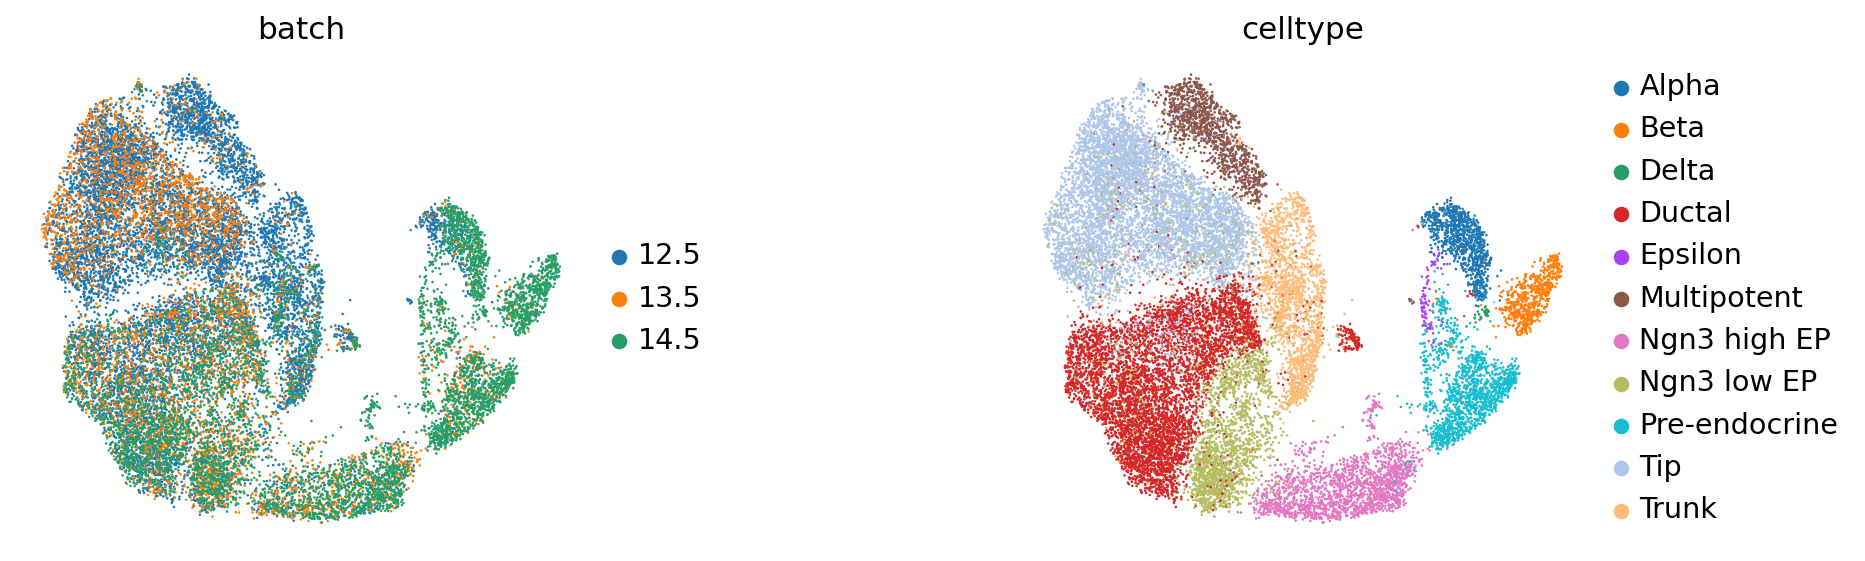

In [23]:
sc.pl.umap(
    reference_latent,
    color=["batch", "celltype"],
    frameon=False,
    wspace=0.6,
)

One can also compute the accuracy of the learned classifier

In [25]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.celltype)))

Acc: 0.9537066281640572


After pretraining the model can be saved for later use

In [26]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

### Query data

In [27]:
query = query[:, reference.var_names]

In [28]:
query.obs['orig_cell_types'] = query.obs[cell_type_key].copy()
query.obs[cell_type_key] = vae.unlabeled_category_

Trying to set attribute `.obs` of view, copying.


In [29]:
model = sca.models.SCANVI.load_query_data(
    query,
    ref_path,
    freeze_dropout = True,
)
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 3756 cells, 2000 vars, 4 batches, 
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
Labelled Indices:  0
Unlabelled Indices:  3756


In [30]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  21%|██        | 105/500 [01:19<05:14,  1.26it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  21%|██        | 105/500 [01:19<05:00,  1.31it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  32 s

In [31]:
query.obsm["latent"] = model.get_latent_representation()

In [32]:
sc.pp.neighbors(query, use_rep="latent")
sc.tl.umap(query)

... storing 'clusters' as categorical


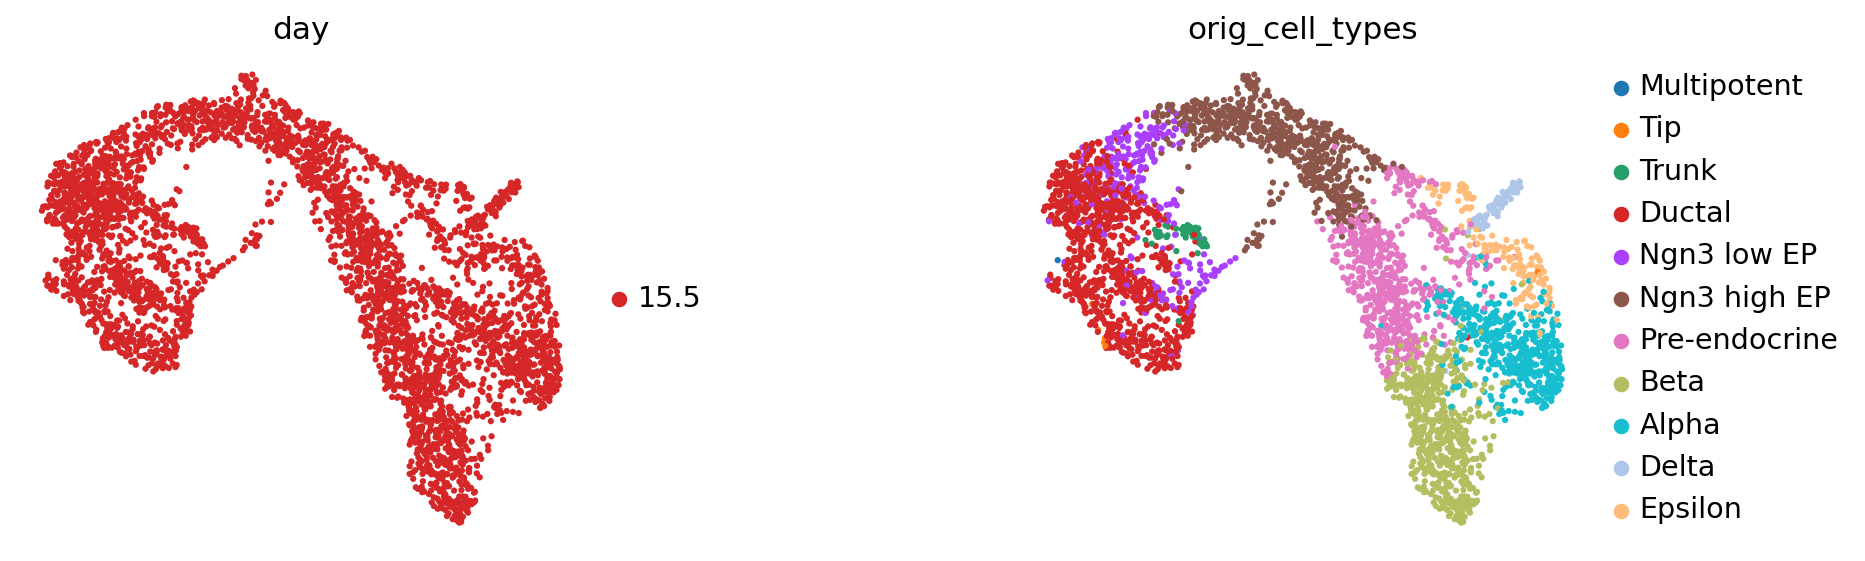

In [33]:
sc.pl.umap(
    query,
    color=["day", "orig_cell_types"],
    frameon=False,
    wspace=0.6,
)

In [34]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [35]:
adata_full = reference.concatenate(query)

Storing latent space in the original adata file 

In [36]:
adata.obsm["latent"] = model.get_latent_representation(adata=adata_full)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 25919 cells, 2000 vars, 4 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


runing UMAP on original data but using latent

In [37]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

In [38]:
adata.obs["day"].unique()

['12.5', '13.5', '14.5', '15.5']
Categories (4, object): ['12.5', '13.5', '14.5', '15.5']

In [39]:
adata.obs["day"].replace(['12.5', '13.5', '14.5', '15.5'],
                         ['12.5 (reference)', '13.5 (reference)', '14.5 (reference)', '15.5 (query)'],inplace=True)

In [40]:
adata.write_h5ad(filename=f'full_processed_data.h5ad')

... storing 'day' as categorical


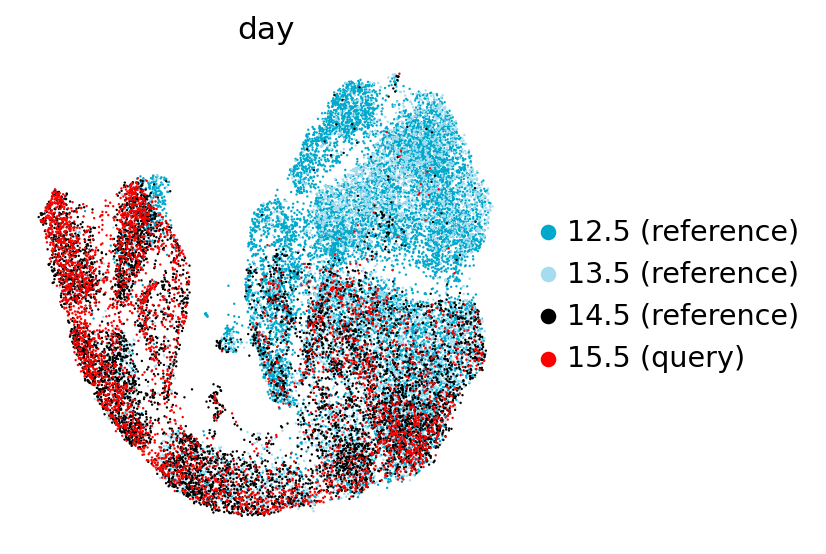

In [41]:
sc.pl.umap(
    adata,
    color=["day"],
    palette=["#00a8cc","#a6dcef","black","red"],
    frameon=False,
    wspace=0.6,
save="yes4")

In [42]:
scv.settings.set_figure_params('scvelo')  # for beautified visualization

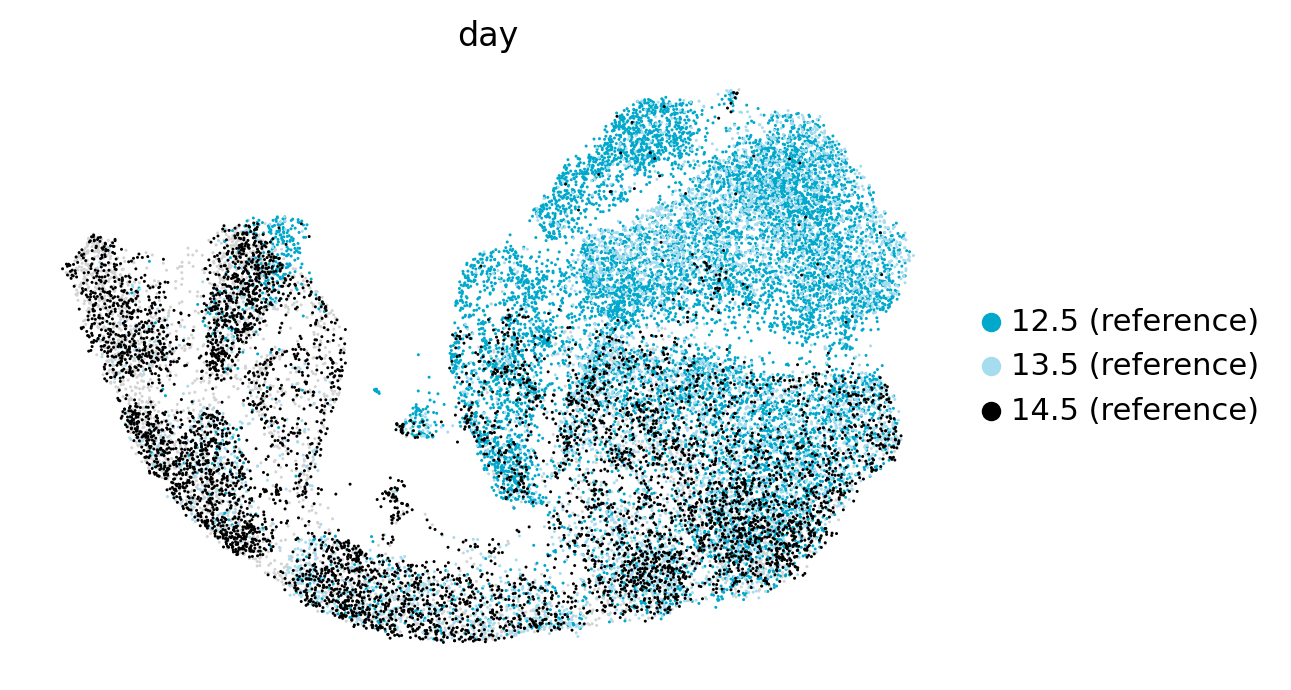

In [43]:
sc.pl.umap(
    adata,
    color=["day"],
    palette=["#00a8cc","#a6dcef","black","red"],
    frameon=False,
    groups=['12.5 (reference)', '13.5 (reference)', '14.5 (reference)'],
    wspace=0.6,
    save="yes3")

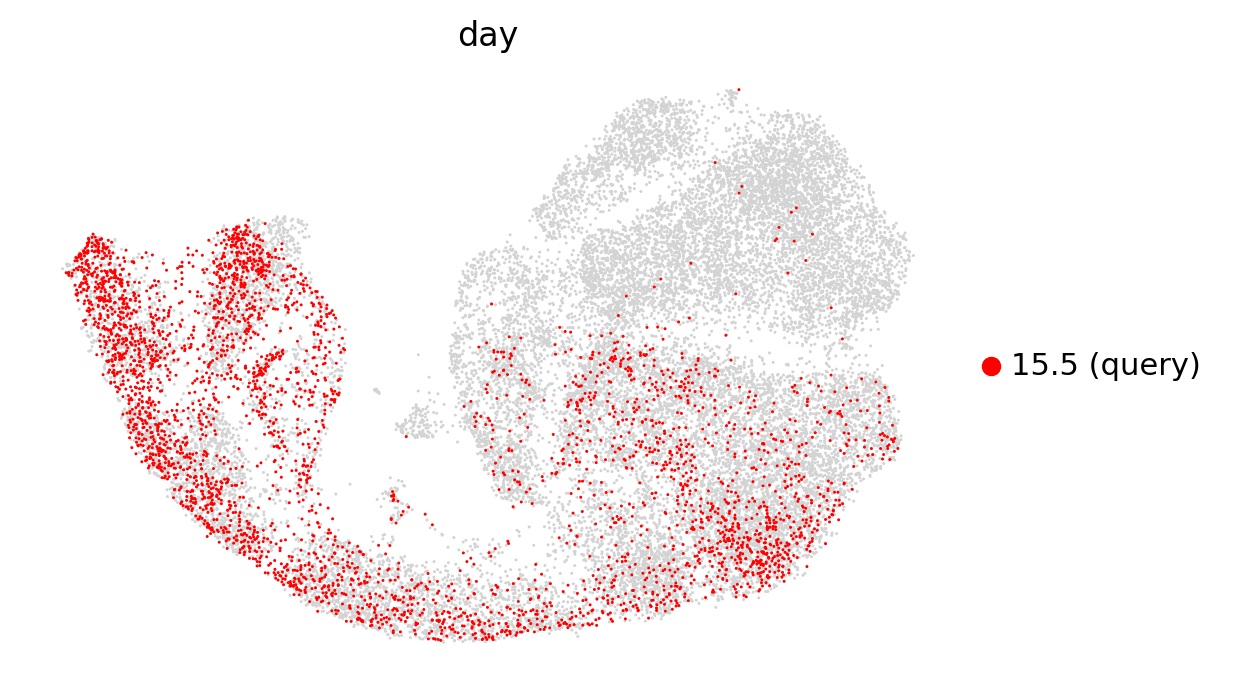

In [44]:
sc.pl.umap(
    adata,
    color=["day"],
    palette=["#00a8cc","#a6dcef","black","red"],
    frameon=False,
    groups='15.5 (query)',
    wspace=0.6,
    save="yes")

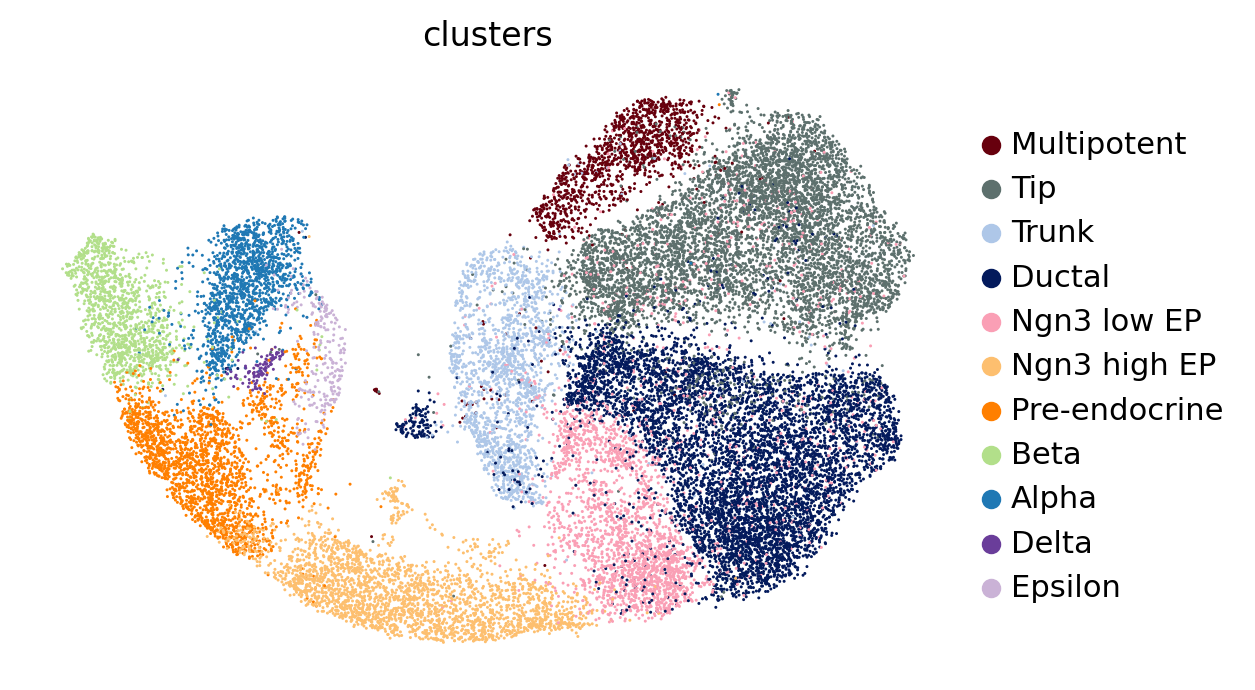

In [45]:
sc.pl.umap(
    adata,
    color=["clusters"],
    frameon=False,
    wspace=0.6,
    save="yes2")

## scvelo analysis 

In [46]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 17278 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [47]:
adata.obs["day"]

index
AAACCTGAGCACCGCT-1-0    12.5 (reference)
AAACCTGAGCGCTTAT-1-0    12.5 (reference)
AAACCTGAGGGAAACA-1-0    12.5 (reference)
AAACCTGAGGTACTCT-1-0    12.5 (reference)
AAACCTGAGTCACGCC-1-0    12.5 (reference)
                              ...       
TTTGTCAAGTGACATA-1-3        15.5 (query)
TTTGTCAAGTGTGGCA-1-3        15.5 (query)
TTTGTCAGTTGTTTGG-1-3        15.5 (query)
TTTGTCATCGAATGCT-1-3        15.5 (query)
TTTGTCATCTGTTTGT-1-3        15.5 (query)
Name: day, Length: 25919, dtype: category
Categories (4, object): ['12.5 (reference)', '13.5 (reference)', '14.5 (reference)', '15.5 (query)']

In [48]:
for d in adata.obs["day"].unique():
    scv.tl.velocity(adata, groups_for_fit=[d], groupby="day")

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [49]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:01:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_save_2.pdf.png


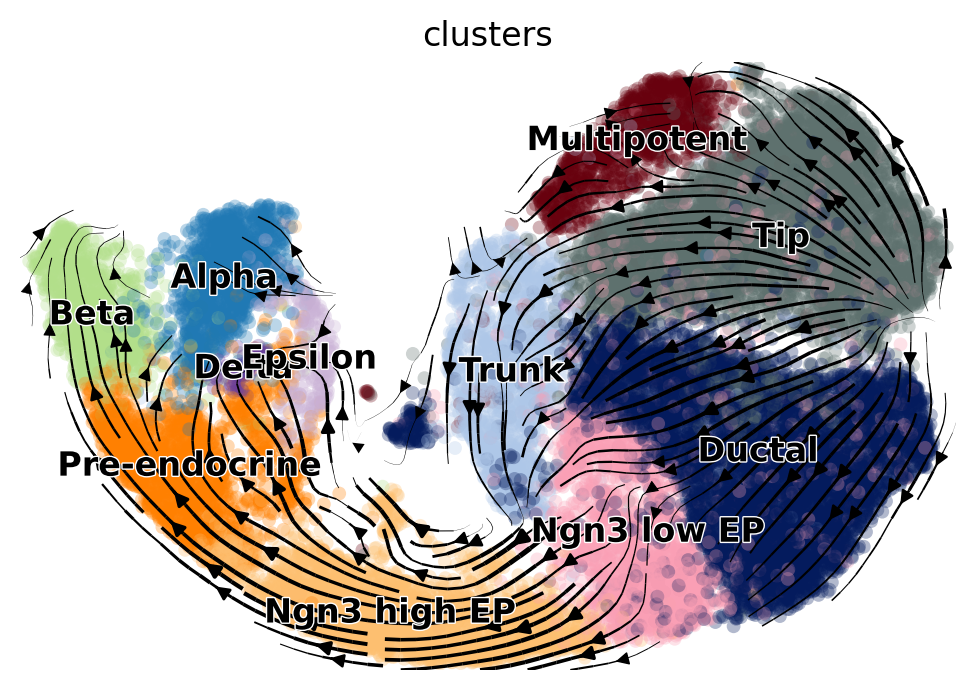

In [50]:
scv.pl.velocity_embedding_stream(adata, basis='umap',save="save_2")


saving figure to file ./figures/scvelo_scv1.pdf


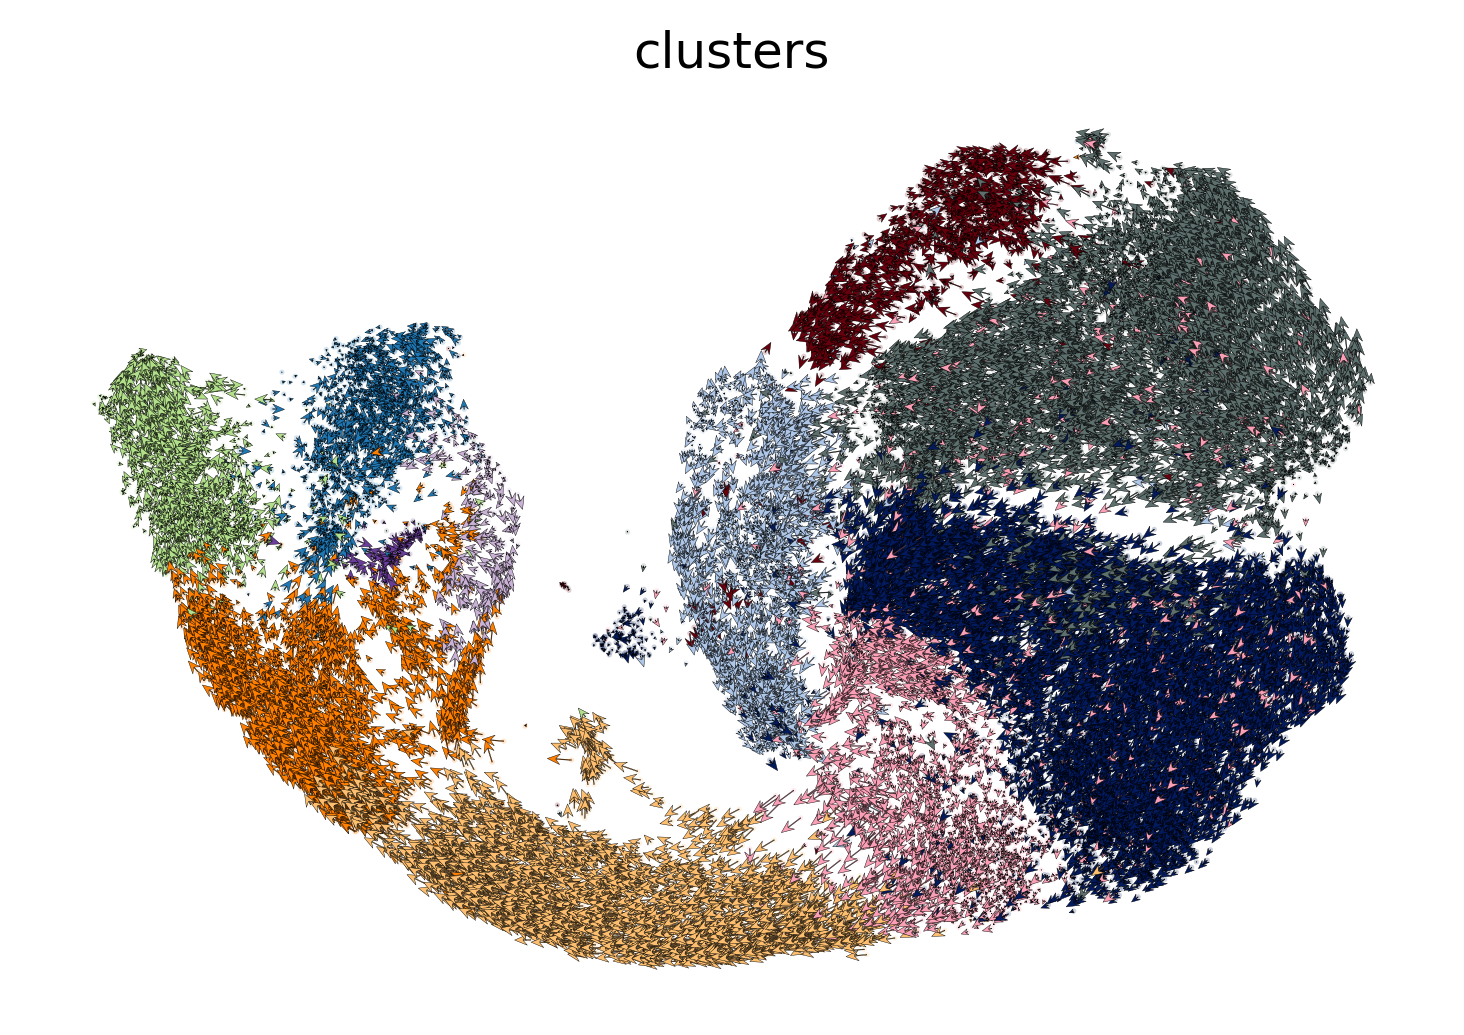

In [51]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=10, arrow_size=1.5, dpi=150,save="scv1")
